## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement a new web page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(6)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0


I will use cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [5]:
df_con = df.query('converted == True').nunique().sum() / df.nunique().sum()
df_con

0.1203535315553064

The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [7]:
df.isnull().count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

Now use the answer to create a new data set df2.

In [8]:
df2 = df.drop(df.query('group == "treatment" and landing_page == "old_page" or group =="control" and landing_page == "new_page"').index)

In [9]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False]

,user_id,timestamp,group,landing_page,converted


The unique **user_id**s are in **df2**

In [10]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.  

In [11]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop_duplicates(['user_id'], keep='last', inplace=True)

Below is the probability of an individual converting regardless of the page they receive.

In [13]:
df_con = df2.query('converted == True').count() / df2.count()
df_con

user_id         0.119597
timestamp       0.119597
group           0.119597
landing_page    0.119597
converted       0.119597
dtype: float64

Given that an individual was in the `control` group, below is the probability they converted.

In [14]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted is below.

In [15]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

The probability the individual got the new page.

In [16]:
df2.query('landing_page == "new_page"').count() /(df2.landing_page.count())

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

Explained below is whether i think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

It does not have sufficient evidence that the treatment page leads to more conversions. There was a 50% chance that someone would recieve either page when coming to the website. If someone received the treatment page, they had a 0.15% less of a chance that the persone would convert than if they recieved the control page. However, we have not taken the amount of time this was used for into consideration which could impact the experiment. 

<a id='ab_test'></a>
### Part II - A/B Test
I will consider the need to make the decision just based on all the data provided. Below is the Null hypothesis asuuming the old page being better than the new page.

Null = **$p_{old}$** > **$p_{new}$**         
Alternative = **$p_{old}$** < **$p_{new}$**

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Then use the cells below to provide the necessary parts of this simulation.  

 **Conversion rate** for $p_{new}$ under the null.

In [17]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**Conversion rate** for $p_{old}$ under the null. <br><br>

In [18]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group.

In [19]:
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

 $n_{old}$, the number of individuals in the control group.

In [20]:
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

We will simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null and then Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17538

We will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null and then store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17421

$p_{new}$ - $p_{old}$ for your simulated values from above.

In [23]:
diff = (new_page_converted/n_new) - (old_page_converted/n_old)
diff

0.00077546585888227382

Bootstrap 10,000 $p_{new}$ - $p_{old}$ values and storing all values in a NumPy array called **p_diffs**.

In [24]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

Plot a histogram of the **p_diffs**.  

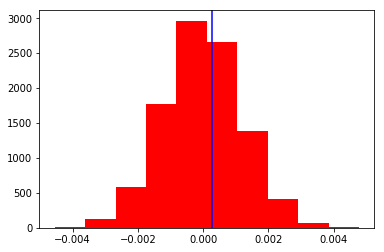

In [25]:
plt.hist(p_diffs,color='red');
plt.axvline(x=diff, color='blue');

Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**.

In [26]:
act_diffs = df2.query('group == "treatment"')['converted'].mean()-df2.query('group == "control"')['converted'].mean()
act_diffs

-0.0015782389853555567

In [27]:
(p_diffs > act_diffs).mean()

0.90559999999999996

Explination of findings are below. 

**The differnce is greater than our alpha of 0.05 which indicates we fail to reject the null.**

We could also use a built-in to achieve similar results. In the below cell we will calculate the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` will refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

conversions_old = df2.query('group == "control"')['converted'].sum()
conversions_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now we will use `stats.proportions_ztest` to compute the test statistic and p-value. 

In [34]:
z_score, p_val = sm.stats.proportions_ztest(count=[conversions_new, conversions_old], nobs=[n_new, n_old],  alternative= 'larger')
print("z-score:", z_score,"p-value:", p_val)

z-score: -1.31092419842 p-value: 0.905058312759


The z-score and p-value you computed in the previous questioncompared to the conversion rates of the old and new pages.

**The p value is greater than alpha (0.5) so we fail to reject the null. The z score also is negative showing that we have ourd data value is 1.31 standard deviations smaller than also failing to reject the null.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, below is the explination of why we would use a simple linear regression.

**We would perform a simple linear regression since they are quantitative values and are either true or false.**

First we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.

In [35]:
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']

We will now instantiate the regression model on the two columns created in above and then fit the model to predict whether or not an individual converts. 

In [36]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of results are below.

In [37]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-30 19:28 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

**p value = 0.1899. it doesnt differ from when we used the z score to calculate the p value.**

**There are factors in the raw data that were not given. Taking into account some of the other factors (columns) could also play a role into impacting the significance of the conversion rate.**

Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in. 

First we will read in the document for countries and joing the data sets on the user id column.

In [38]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])

Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

Below is the log model fit with the results.

In [41]:
logit2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA']])
result2 = logit2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-30 19:31 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0450    0.0266  -76.8197  0.0000  -2.0971  -1.9928
ab_page        0.0149    0.0114    1.3069  0.1912  -0.0075   0.0374
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**We see a larger conversion rate for the US and UK compared to CA by looking at the COEF. You can also see there is a difference in the conversion rates from the the countries based on their p-val.**

Now lets look at the differnece between the countries in our samples vs the raw data.

In [42]:
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
logit3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-30 19:32 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0715    0.0371  -55.7977  0.0000  -2.1442  -1.9987
ab_page        0.0674    0.0520    1.2967  0.1947  -0.0345   0.1694
UK             0.0901    0.0405    2.2252  0.0261   0.0107   0.1694
CA             0.0644    0.0384    1.6788  0.0932  -0.0108   0.1396
UK_ab_page    -0.0783    0.0568   -1.3783  0.1681  -0.1896   0.0330
CA_ab_page    -0.0469    0.0538   -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

**As you can see, the counties using the raw data have a less significant impact (comparing p values) than when using the raw data from the AB Page.**

**However, we have no reason to reject the null hypothesis based on the results. The signifincae from one country to the next is still less than our 95% alpha rating. Since we have such a large sample size, the evidence suggest that the alternative did not have a higher conversion rate. Trying a more significant change in the experiment page might provide better results as these do no show a difference.**

In [37]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0